<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/kRR_Category_Classification_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import os
import zipfile
import requests

zip_path = os.path.join(os.getcwd(), "wine.zip")
csv_folder_path = os.path.join(os.getcwd(), "wine")
csv_wine_path = os.path.join(csv_folder_path, "winequality-red.csv")

response = requests.get("https://archive.ics.uci.edu/static/public/186/wine+quality.zip", params={"downloadformat": "zip"})

with open(zip_path, mode="wb") as file:
    file.write(response.content)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(csv_folder_path)


In [36]:
# charger les données
import pandas as pd
data = pd.read_csv(csv_wine_path, sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [37]:
# créer la matrice de données
X = data[data.columns[:-1]].values

# créer le vecteur d'étiquettes
y = data['quality'].values

# créer un jeu d'entrainement et un jeu de test (30% des données)
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, test_size=0.3)

# standardiser les données
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [38]:
from sklearn import kernel_ridge
import numpy as np

predicteur = kernel_ridge.KernelRidge(
    alpha=1.0, # valeur par défaut
    kernel='rbf', # noyau Gaussien
    gamma=50.0)   # valeur par défaut

# entraîner le classifieur sur le jeu d'entrainement
predicteur.fit(X_train_std, y_train)

# prédire sur le jeu de test
y_test_pred = predicteur.predict(X_test_std)

# calculer la RMSE sur le jeu de test
from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print("RMSE: {:.2f}".format(rmse))

RMSE: 5.12


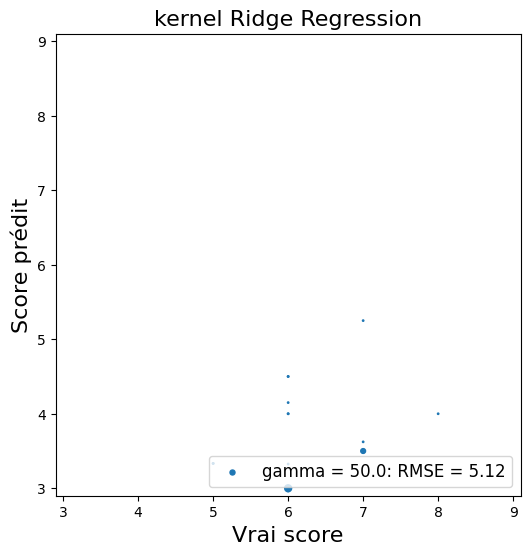

In [39]:
from matplotlib import pyplot as plt

# créer une figure
fig = plt.figure(figsize=(6, 6))

# Compter, pour chaque paire de valeurs (y, y') où y est un vrai score et y' le score prédit,
# le nombre de ces paires.
# Ce nombre sera utilisé pour modifier la taille des marqueurs correspondants
# dans un nuage de points
sizes = {}
for (yt, yp) in zip(list(y_test), list(y_test_pred)):
    if (yt, yp) in sizes.keys():
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1
keys = sizes.keys()

# afficher les prédictions
plt.scatter([k[0] for k in keys],
            [k[1] for k in keys],
             s=[sizes[k] for k in keys],
            label="gamma = 50.0: RMSE = {:.2f}".format(rmse))

# étiqueter les axes et le graphique
plt.xlabel('Vrai score', fontsize=16)
plt.ylabel(u'Score prédit', fontsize=16)
plt.title('kernel Ridge Regression', fontsize=16)

# limites des axes
plt.xlim([2.9, 9.1])
plt.ylim([2.9, 9.1])

# afficher la légende
plt.legend(loc="lower right", fontsize=12)

In [40]:
# valeurs du paramètre C
alpha_range = np.logspace(-2, 2, 5)

# valeurs du paramètre gamma
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_mean_squared_error'

# initialiser la validation croisée
grid_pred = model_selection.GridSearchCV(
        kernel_ridge.KernelRidge(kernel='rbf'),
        param_grid,
        cv=5,
        scoring=score)

# exécuter la validation croisée sur le jeu d'entraînement
grid_pred.fit(X_train_std, y_train)

# prédire sur le jeu de test avec le modèle sélectionné
y_test_pred_cv = grid_pred.predict(X_test_std)

# calculer la RMSE correspondante
rmse_cv = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_cv))
print("RMSE: {:.2f}".format(rmse_cv))

RMSE: 0.66
